In [9]:
from functools import partial, reduce
from pathlib import Path

import numpy as np
import tensorflow as tf
import tensorflow.data as tfd
from tensorflow.data import Dataset as tfds
from keras_cv.layers import GridMask, RandomChannelShift, RandomHue
from keras.layers import RandomRotation, RandomTranslation
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

In [10]:
DATA_DIR = Path().absolute().parent / "data"
DATA_PATH = DATA_DIR / "training_set.npz"
OUTPUT_DIR = DATA_DIR / "augmented"

In [11]:
with np.load(DATA_PATH) as data:
    images: np.ndarray = data["images"]
    labels: np.ndarray = data["labels"]

print(images.shape)
print(labels.shape)

(13759, 96, 96, 3)
(13759, 1)


## Cleaning

In [12]:
image_means: np.ndarray = images.mean(axis=(1, 2, 3))

In [13]:
TOLERANCE = 1e-4
MIN_DUPLICATES = 5

mean_indices = {}
for mean in image_means:
    indices = (np.abs(mean - image_means) <= TOLERANCE).nonzero()[0]
    if len(indices) > MIN_DUPLICATES:
        mean_indices[mean] = indices

len(mean_indices.keys())

2

In [14]:
duplicated_indices = []
for indices in mean_indices.values():
    duplicated_indices.extend(indices)
duplicated_indices = np.array(duplicated_indices)
duplicated_indices.shape

(1800,)

In [15]:
original_indices = np.setdiff1d(
    list(range(images.shape[0])),
    duplicated_indices
)
original_indices.shape

(11959,)

In [16]:
clean_images = images[original_indices]
clean_labels = labels[original_indices]

print(clean_images.shape)
print(clean_labels.shape)

(11959, 96, 96, 3)
(11959, 1)


## Validation split

In [17]:
images_train, images_val, labels_train, labels_val = train_test_split(
    clean_images, clean_labels,
    test_size=1500,
    random_state=42,
    stratify=clean_labels,
)

print(images_train.shape)
print(labels_train.shape)

print(images_val.shape)
print(labels_val.shape)

(10459, 96, 96, 3)
(10459, 1)
(1500, 96, 96, 3)
(1500, 1)


In [18]:
train_dataset = tfds.from_tensor_slices((images_train, labels_train))
val_dataset = tfds.from_tensor_slices((images_val, labels_val))
train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(1,), dtype=tf.uint8, name=None))>

## Augmentation

In [19]:
unique_labels, counts = np.unique(clean_labels, return_counts=True)
count_proportion = counts / counts.max()
count_proportion

array([0.36566524, 0.9360515 , 0.46566524, 0.8695279 , 0.36437768,
       0.42618026, 1.        , 0.70515021])

In [20]:
REPEAT_FACTOR = 1.2
CLASS_REBALANCE = 0.8

repeat_factor = np.ceil(REPEAT_FACTOR * (CLASS_REBALANCE / count_proportion)).astype("int")
repeat_factor

array([3, 2, 3, 2, 3, 3, 1, 2])

In [21]:
repeat_per_label = {
    i: repeat_factor_i
    for i, repeat_factor_i in enumerate(repeat_factor)
}
repeat_per_label

{0: 3, 1: 2, 2: 3, 3: 2, 4: 3, 5: 3, 6: 1, 7: 2}

In [22]:
def augment(
    dataset: tfds,
    repeat: dict[int, int] | None = None,
) -> tfds:
    AUGMENTATIONS = [
        RandomTranslation((-0.15, 0.15), (-0.15, 0.15), fill_mode="wrap"),
        RandomRotation(1.0, fill_mode="wrap"),
        RandomChannelShift(value_range=(0, 255), factor=(0.05, 0.3)),
        RandomHue(value_range=(0, 255), factor=(0.05, 0.3)),
        GridMask(),
    ]

    def augmentation_function(x, y):
        augmentations_dict = {
            i: partial(augmentation, x) for i, augmentation in enumerate(AUGMENTATIONS)
        }
        i = tf.random.uniform([], maxval=len(augmentations_dict), dtype=tf.int32)
        augmented_x = tf.cast(tf.switch_case(i, augmentations_dict), tf.uint8)
        return augmented_x, y

    if repeat is not None:
        datasets = [
            dataset.batch(1).filter(
                lambda _, y: tf.reduce_all(y == repeat_y)
            ).unbatch().repeat(factor)
            for repeat_y, factor in repeat.items()
        ]
        dataset = reduce(lambda d1, d2: d1.concatenate(d2), datasets)

    return dataset.map(augmentation_function, num_parallel_calls=tfd.AUTOTUNE)

In [23]:
def one_hot_encode(x, y, num_classes=8):
    return (
        x,
        tf.reshape(
            tf.cast(to_categorical(y, num_classes=num_classes), tf.uint8),
            [-1],
        )
    )

In [24]:
augmented_train_dataset = (
    augment(train_dataset, repeat_per_label)
    .concatenate(train_dataset)
    .map(one_hot_encode, num_parallel_calls=tfd.AUTOTUNE)
)
augmented_train_dataset.save(str(OUTPUT_DIR / "train"))

augmented_val_dataset = (
    augment(val_dataset, repeat_per_label)
    .concatenate(val_dataset)
    .map(one_hot_encode, num_parallel_calls=tfd.AUTOTUNE)
)
augmented_val_dataset.save(str(OUTPUT_DIR / "val"))

## Analysis

In [3]:
augmented_train_dataset = tfds.load(str(OUTPUT_DIR / "train"))
augmented_val_dataset = tfds.load(str(OUTPUT_DIR / "val"))

In [25]:
augmented_train_dataset.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(96, 96, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(8,), dtype=tf.uint8, name=None))>

In [26]:
len([sample for sample in augmented_train_dataset])

2024-11-13 11:47:23.793643: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


32644

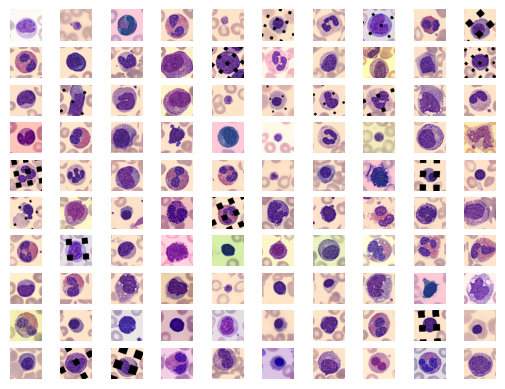

In [27]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=10, ncols=10)
axes = axes.reshape((-1))

for ax, (image, _) in zip(axes, augmented_train_dataset.shuffle(28_000).as_numpy_iterator()):
    ax.set_axis_off()
    ax.imshow(image)

In [28]:
labels = [y for (_, y) in augmented_train_dataset.as_numpy_iterator()]
np.unique(np.concatenate(labels), return_counts=True)

2024-11-13 11:47:34.566965: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(array([0, 1], dtype=uint8), array([228508,  32644]))